<a href="https://colab.research.google.com/github/hassen8/emotion_recognition_bias_auditing/blob/master/notebooks/EmotiEffLib_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install + imports

In [3]:
!pip -q install emotiefflib[torch] opencv-python tqdm pandas matplotlib pillow==10.2.0
!pip -q install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip uninstall -y pillow
!pip install pillow==10.2.0

Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
  Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)


In [2]:
import os, json, re
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import top_k_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from emotiefflib.facial_analysis import EmotiEffLibRecognizer
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

np.random.seed(0)
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


# Canonical labels

In [3]:
# 7-class canonical order (RAF/DeepFace-compatible)
EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# RAF integer labels -> strings
RAF_ID_TO_EMO = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral",
}

# EmotiEffLib/HSEmotion 8-class order (includes contempt)
EMOTIONS_8 = ["angry", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
IDX8 = {e:i for i,e in enumerate(EMOTIONS_8)}

# Dataset setup

In [5]:
ZIP_PATH   = "/content/drive/MyDrive/Image/aligned.zip"
LABEL_PATH = "/content/drive/MyDrive/EmoLabel/list_patition_label.txt"

!unzip -oq "{ZIP_PATH}" -d /content
!cp "{LABEL_PATH}" /content/list_patition_label.txt

IMAGE_DIR  = Path("/content/aligned")
LABEL_FILE = Path("/content/list_patition_label.txt")

print("IMAGE_DIR:", IMAGE_DIR, "exists:", IMAGE_DIR.exists())
print("LABEL_FILE:", LABEL_FILE, "exists:", LABEL_FILE.exists())

IMAGE_DIR: /content/aligned exists: True
LABEL_FILE: /content/list_patition_label.txt exists: True


In [6]:
def load_raf_df(image_dir: Path, label_file: Path, split: str):
    df = pd.read_csv(label_file, sep=" ", header=None, names=["filename", "label"])

    if split == "train":
        df = df[df["filename"].str.startswith("train")]
    elif split == "test":
        df = df[df["filename"].str.startswith("test")]
    else:
        raise ValueError("split must be 'train' or 'test'")

    df["aligned_filename"] = df["filename"].str.replace(".jpg", "_aligned.jpg", regex=False)
    df["file_path"] = df["aligned_filename"].apply(lambda x: str(image_dir / x))
    df.drop(columns=["aligned_filename"], inplace=True)

    df["emotion_label"] = df["label"].map(RAF_ID_TO_EMO)
    df["split"] = split

    df = df[df["file_path"].apply(os.path.exists)].reset_index(drop=True)

    if df["emotion_label"].isna().any():
        raise RuntimeError("Some labels could not be mapped. Check the label file.")

    return df[["file_path", "split", "emotion_label"]]

df_train = load_raf_df(IMAGE_DIR, LABEL_FILE, "train")
df_test  = load_raf_df(IMAGE_DIR, LABEL_FILE, "test")
df = pd.concat([df_train, df_test], ignore_index=True)

print(df.head())
print(df["split"].value_counts())
print(df["emotion_label"].value_counts())

                                  file_path  split emotion_label
0  /content/aligned/train_00001_aligned.jpg  train           sad
1  /content/aligned/train_00002_aligned.jpg  train           sad
2  /content/aligned/train_00003_aligned.jpg  train         happy
3  /content/aligned/train_00004_aligned.jpg  train         happy
4  /content/aligned/train_00005_aligned.jpg  train           sad
split
train    12271
test      3068
Name: count, dtype: int64
emotion_label
happy       5957
neutral     3204
sad         2460
surprise    1619
disgust      877
angry        867
fear         355
Name: count, dtype: int64


# Load EmotiEffLib model + unwrap torch model + choose target layer

In [7]:
MODEL_NAME = "enet_b0_8_best_vgaf"
recognizer = EmotiEffLibRecognizer(engine="torch", model_name=MODEL_NAME, device=device)
print("Loaded:", MODEL_NAME)

def unwrap_torch_model(recognizer):
    for attr in ["model", "net", "backbone", "_model"]:
        if hasattr(recognizer, attr):
            m = getattr(recognizer, attr)
            if isinstance(m, nn.Module):
                return m
    for _, v in recognizer.__dict__.items():
        if isinstance(v, nn.Module):
            return v
    raise RuntimeError("Could not find torch.nn.Module inside recognizer.")

torch_model = unwrap_torch_model(recognizer).to(device).eval()
print("Torch model type:", type(torch_model))

def find_last_conv2d(model: nn.Module):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d layer found for Grad-CAM.")
    return last

target_layer = find_last_conv2d(torch_model)
print("Grad-CAM target layer:", target_layer)

Loaded: enet_b0_8_best_vgaf
Torch model type: <class 'timm.models.efficientnet.EfficientNet'>
Grad-CAM target layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


# Emotiff class order

In [8]:
def get_emotieff_class_names(recognizer):
    # we try common possibilities (library-dependent)
    for attr in ["emotions", "classes", "class_names", "labels"]:
        if hasattr(recognizer, attr):
            v = getattr(recognizer, attr)
            if isinstance(v, (list, tuple)) and len(v) >= 7:
                return [str(x).lower() for x in v]

    return EMOTIONS

EMOTIEFF_CLASSES = get_emotieff_class_names(recognizer)
print("EmotiEffLib class order:", EMOTIEFF_CLASSES)

# Build mapping: EmotiEffLib index -> EMOTIONS index
emo_to_idx = {e:i for i,e in enumerate(EMOTIONS)}
reorder_idx = []
for e in EMOTIONS:
    if e not in EMOTIEFF_CLASSES:
        raise RuntimeError(
            f"EmotiEffLib classes missing '{e}'. Found: {EMOTIEFF_CLASSES}. "
            "You must inspect recognizer class names."
        )
    reorder_idx.append(EMOTIEFF_CLASSES.index(e))

reorder_idx = np.array(reorder_idx, dtype=int)
print("Reorder indices (EMOTIONS <- EmotiEffLib):", reorder_idx)

EmotiEffLib class order: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
Reorder indices (EMOTIONS <- EmotiEffLib): [0 1 2 3 4 5 6]


# Image and model preprocessing

In [9]:
def read_rgb_uint8(path: str):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

tfm = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

def to_model_tensor(face_rgb_uint8):
    return tfm(face_rgb_uint8).unsqueeze(0).to(device)  # (1,3,224,224)

# Prediction function

Outputs probs in canonical EMOTIONS order

In [10]:
def predict_probs7_drop_contempt(face_rgb_uint8):
    """
    Returns:
      probs7: (7,) in EMOTIONS order OR None if predicted contempt (drop)
      pred8_label: str in EMOTIONS_8
      pred7_label: str in EMOTIONS (if not dropped) else None
    """
    pred_label_str, logits = recognizer.predict_emotions([face_rgb_uint8], logits=True)

    logits8 = np.asarray(logits[0], dtype=np.float32)
    if logits8.shape[0] != 8:
        raise RuntimeError(f"Expected 8 logits, got {logits8.shape[0]}")

    probs8 = torch.softmax(torch.tensor(logits8), dim=0).cpu().numpy().astype(np.float32)
    pred8_idx = int(np.argmax(probs8))
    pred8_label = EMOTIONS_8[pred8_idx]

    if pred8_label == "contempt":
        return None, pred8_label, None

    # Build 7-class probs by removing contempt then renormalizing
    keep8 = [IDX8[e] for e in EMOTIONS]  # EMOTIONS is our 7-class order
    probs7 = probs8[keep8]
    probs7 = probs7 / (probs7.sum() + 1e-8)

    pred7_idx = int(np.argmax(probs7))
    pred7_label = EMOTIONS[pred7_idx]

    return probs7, pred8_label, pred7_label

# Batch inference

In [11]:
def run_drop_contempt_eval(df_in, n=None):

    df_in = df_in.reset_index(drop=True)
    N = len(df_in) if n is None else min(int(n), len(df_in))

    y_pred_proba = np.full((N, len(EMOTIONS)), np.nan, dtype=np.float32)

    pred7 = [None] * N
    pred8 = [None] * N
    dropped = np.zeros((N,), dtype=int)
    failures = []

    for i in tqdm(range(N)):
        path = df_in.loc[i, "file_path"]
        face = read_rgb_uint8(path)
        if face is None:
            failures.append({"i": i, "file_path": path, "stage": "read"})
            dropped[i] = 1
            continue

        try:
            probs7, pred8_label, pred7_label = predict_probs7_drop_contempt(face)
            pred8[i] = pred8_label
            pred7[i] = pred7_label

            if probs7 is None:
                dropped[i] = 1  # predicted contempt
            else:
                y_pred_proba[i] = probs7

        except Exception as e:
            failures.append({"i": i, "file_path": path, "stage": "predict", "error": str(e)})
            dropped[i] = 1

    df_out = df_in.iloc[:N].copy()
    df_out["pred7_label"] = pred7
    df_out["pred8_label"] = pred8
    df_out["dropped_contempt"] = dropped

    df_fail = pd.DataFrame(failures)
    return df_out, y_pred_proba, df_fail

df_small = df[df["split"] == "train"].sample(300, random_state=0).reset_index(drop=True)

df_pred, y_pred_proba, df_fail = run_drop_contempt_eval(df_small, n=None)

coverage_7class = np.mean(~np.isnan(y_pred_proba).any(axis=1))
drop_rate_contempt = 1 - coverage_7class

print("Failures:", len(df_fail))
print(f"Coverage (not contempt & no failure): {coverage_7class:.3f}")
print(f"Drop rate: {drop_rate_contempt:.3f}")
print("Dropped (count):", int(df_pred["dropped_contempt"].sum()))
print("Pred8 distribution (top-1):")
print(df_pred["pred8_label"].value_counts(dropna=False))

100%|██████████| 300/300 [00:28<00:00, 10.41it/s]

Failures: 0
Coverage (not contempt & no failure): 0.977
Drop rate: 0.023
Dropped (count): 7
Pred8 distribution (top-1):
pred8_label
happy       94
sad         64
neutral     45
angry       42
fear        21
surprise    17
disgust     10
contempt     7
Name: count, dtype: int64


# Metrics

Valid samples for metrics: 293/300 (coverage=0.977)
Top-1 Accuracy: 0.4642
Top-3 Accuracy: 0.6997
F1 Macro:       0.3670
F1 Weighted:    0.4534

              precision    recall  f1-score   support

       angry       0.40      0.77      0.53        22
     disgust       0.50      0.31      0.38        16
        fear       0.33      0.88      0.48         8
       happy       1.00      0.90      0.95       104
         sad       0.19      0.20      0.19        60
    surprise       0.00      0.00      0.00        54
     neutral       0.02      0.03      0.03        29

    accuracy                           0.46       293
   macro avg       0.35      0.44      0.37       293
weighted avg       0.46      0.46      0.45       293



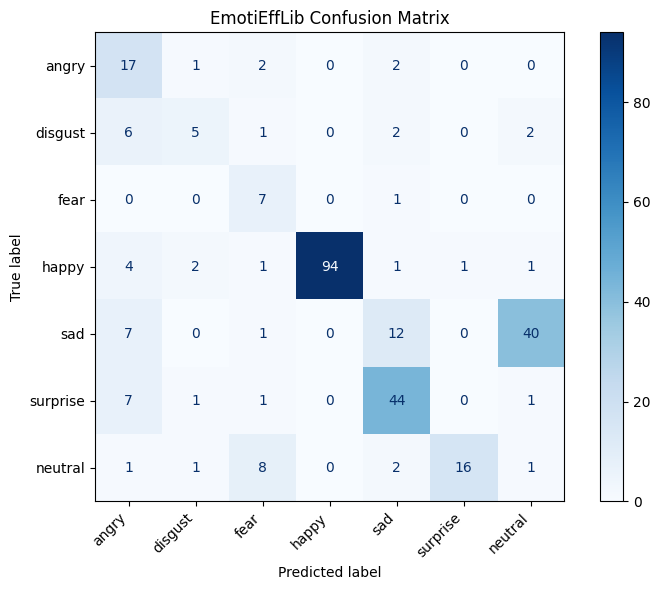

In [12]:
le = LabelEncoder()
le.fit(EMOTIONS)

y_true = le.transform(df_pred["emotion_label"].values)

valid = ~np.isnan(y_pred_proba).any(axis=1)
y_true_v = y_true[valid]
y_prob_v = y_pred_proba[valid]
y_pred_v = np.argmax(y_prob_v, axis=1)

ALL_LABELS = np.arange(len(EMOTIONS))

print(f"Valid samples for metrics: {valid.sum()}/{len(valid)} (coverage={valid.mean():.3f})")

top1 = top_k_accuracy_score(y_true_v, y_prob_v, k=1, labels=ALL_LABELS)
top3 = top_k_accuracy_score(y_true_v, y_prob_v, k=3, labels=ALL_LABELS)
f1m  = f1_score(y_true_v, y_pred_v, average="macro", labels=ALL_LABELS)
f1w  = f1_score(y_true_v, y_pred_v, average="weighted", labels=ALL_LABELS)

print(f"Top-1 Accuracy: {top1:.4f}")
print(f"Top-3 Accuracy: {top3:.4f}")
print(f"F1 Macro:       {f1m:.4f}")
print(f"F1 Weighted:    {f1w:.4f}\n")

print(classification_report(
    y_true_v, y_pred_v,
    target_names=EMOTIONS,
    labels=ALL_LABELS,
    zero_division=0
))

cm = confusion_matrix(y_true_v, y_pred_v, labels=ALL_LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("EmotiEffLib Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ECE

In [13]:
def compute_ece(y_true, y_pred_proba, n_bins=15):
    """
    Multi-class Expected Calibration Error (ECE).
    y_true: (N,) int labels
    y_pred_proba: (N,C) probs
    """
    confidences = np.max(y_pred_proba, axis=1)
    predictions = np.argmax(y_pred_proba, axis=1)
    accuracies = (predictions == y_true).astype(np.float32)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i + 1]
        in_bin = (confidences > lo) & (confidences <= hi)
        prop = in_bin.mean()

        if prop > 0:
            acc_bin = accuracies[in_bin].mean()
            conf_bin = confidences[in_bin].mean()
            ece += abs(acc_bin - conf_bin) * prop

    return float(ece)

# Recompute valid mask safely;  NaNs indicate dropped/invalid)
valid = ~np.isnan(y_pred_proba).any(axis=1)

y_true = le.transform(df_pred["emotion_label"].values)
y_true_v = y_true[valid]
y_prob_v = y_pred_proba[valid]

ece = compute_ece(y_true_v, y_prob_v, n_bins=15)
print(f"ECE (valid subset): {ece:.4f}")

ECE (valid subset): 0.2892


# Reliability diagram

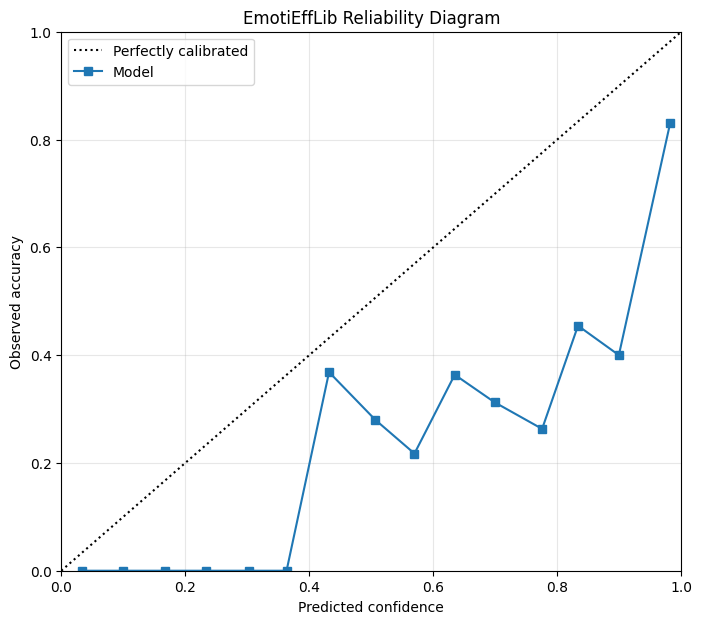

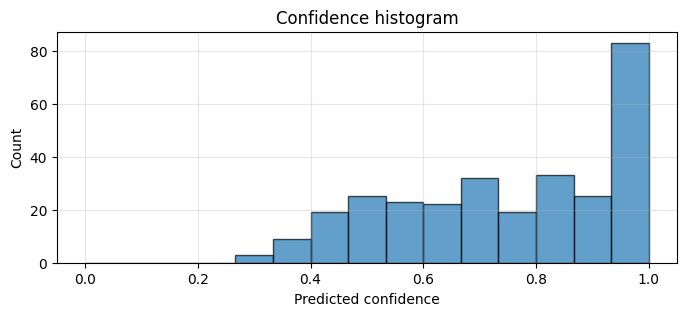

In [14]:
def plot_reliability_diagram(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)
    correct = (predictions == y_true)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_acc, bin_conf, bin_counts = [], [], []

    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i+1]
        in_bin = (confidences > lo) & (confidences <= hi)
        c = in_bin.sum()
        bin_counts.append(c)

        if c > 0:
            bin_acc.append(correct[in_bin].mean())
            bin_conf.append(confidences[in_bin].mean())
        else:
            bin_acc.append(0.0)
            bin_conf.append((lo + hi) / 2)

    plt.figure(figsize=(8, 7))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(bin_conf, bin_acc, "s-", label="Model")
    plt.xlabel("Predicted confidence")
    plt.ylabel("Observed accuracy")
    plt.title(title)
    plt.ylim(0, 1); plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.hist(confidences, bins=bin_edges, edgecolor="black", alpha=0.7)
    plt.xlabel("Predicted confidence")
    plt.ylabel("Count")
    plt.title("Confidence histogram")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_reliability_diagram(y_true_v, y_prob_v, n_bins=15, title="EmotiEffLib Reliability Diagram")

# Grad-CAM:

In [18]:
import cv2
import numpy as np

def overlay_gradcam(face_rgb_uint8, cam_map_01, alpha=0.45):
    """
    face_rgb_uint8: (H,W,3) uint8 RGB
    cam_map_01:     (h,w) float in [0,1] OR any float map (will be normalized)
    Returns:
      cam_uint8 (H,W) uint8
      heat_color (H,W,3) uint8 RGB
      overlay (H,W,3) uint8 RGB
    """
    H, W = face_rgb_uint8.shape[:2]

    # Resize CAM to face size
    cam_resized = cv2.resize(cam_map_01.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)

    # Normalize to [0,1]
    cam_resized = np.maximum(cam_resized, 0)
    cam_min, cam_max = float(cam_resized.min()), float(cam_resized.max())
    cam_norm = (cam_resized - cam_min) / (cam_max - cam_min + 1e-8)

    cam_uint8 = np.uint8(255 * cam_norm)

    # Apply colormap (OpenCV gives BGR)
    heat_bgr = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heat_rgb = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB)

    # Blend
    overlay = cv2.addWeighted(face_rgb_uint8, 1 - alpha, heat_rgb, alpha, 0)

    return cam_uint8, heat_rgb, overlay


In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

SKIP_CONTEMPT = True

def gradcam_on_face(face_rgb_uint8):
    """
    Returns:
      pred8_label (str)
      cam_map (2D float32) raw Grad-CAM map (not resized)
      face_disp (H,W,3) uint8 RGB (same as input)
      cam_vis (H,W,3) uint8 RGB overlay (DeepFace-style)
      cam_uint8 (H,W) uint8 resized CAM for saving/inspection
    """
    # 1) Get logits for target selection
    _, logits = recognizer.predict_emotions([face_rgb_uint8], logits=True)
    logits8 = np.asarray(logits[0], dtype=np.float32)

    pred8_idx = int(np.argmax(logits8))
    pred8_label = EMOTIONS_8[pred8_idx]

    if SKIP_CONTEMPT and pred8_label.lower() == "contempt":

        return pred8_label, None, face_rgb_uint8, None, None

    # 2) Forward tensor
    x = to_model_tensor(face_rgb_uint8)

    # 3) Grad-CAM
    cam = GradCAM(model=torch_model, target_layers=[target_layer])
    cam_map = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred8_idx)])[0].astype(np.float32)

    # 4) resize cam -> face
    cam_uint8, heat_rgb, cam_vis = overlay_gradcam(face_rgb_uint8, cam_map, alpha=0.45)

    return pred8_label, cam_map, face_rgb_uint8, cam_vis, cam_uint8


GT: happy
Pred8: angry
Pred7: angry


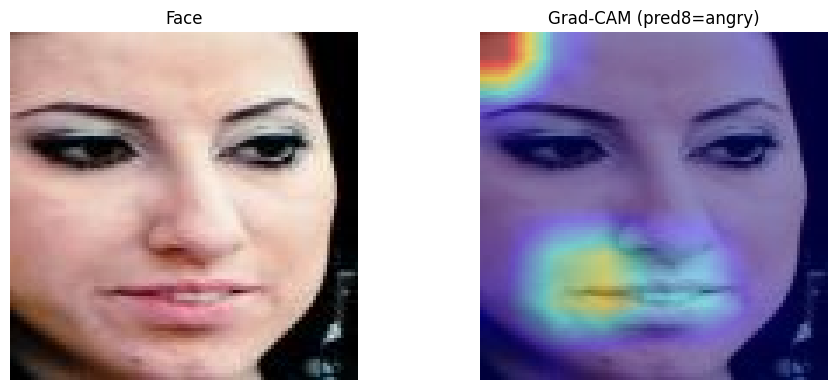

In [20]:
valid_idxs = np.where(valid)[0]
demo_i = int(valid_idxs[0])

p = df_pred.loc[demo_i, "file_path"]
face = read_rgb_uint8(p)

pred8_label, cam_map, face_disp, cam_vis, cam_uint8 = gradcam_on_face(face)

print("GT:", df_pred.loc[demo_i, "emotion_label"])
print("Pred8:", pred8_label)
print("Pred7:", df_pred.loc[demo_i, "pred7_label"])

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(face_disp); plt.axis("off"); plt.title("Face")

plt.subplot(1,2,2)
if cam_vis is None:
    plt.imshow(face_disp); plt.title("Grad-CAM skipped (contempt)")
else:
    plt.imshow(cam_vis); plt.title(f"Grad-CAM (pred8={pred8_label})")
plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
from pathlib import Path
from PIL import Image

OUT_DIR = Path("/content/emotiefflib_protocolA_outputs")
(OUT_DIR / "gradcam_overlays").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "gradcam_heatmaps_uint8").mkdir(parents=True, exist_ok=True)

def show_and_save_gradcam(i, save=True):
    """
    i: index into df_pred/y_pred_proba arrays
    Only call this for valid samples.
    """
    i = int(i)
    path = df_pred.loc[i, "file_path"]
    true_label = df_pred.loc[i, "emotion_label"]
    pred7_label = df_pred.loc[i, "pred7_label"]

    face = read_rgb_uint8(path)
    if face is None:
        print("Failed to read:", path)
        return

    pred8_label, cam_map, face_disp, cam_vis, cam_uint8 = gradcam_on_face(face)

    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.imshow(face_disp); plt.axis("off")
    plt.title(f"Face\nGT={true_label}")

    plt.subplot(1,2,2)
    if cam_vis is None:
        plt.imshow(face_disp); plt.axis("off")
        plt.title(f"Grad-CAM skipped\npred8={pred8_label}")
    else:
        plt.imshow(cam_vis); plt.axis("off")
        plt.title(f"Grad-CAM\npred7={pred7_label} | pred8={pred8_label}")

    plt.tight_layout()
    plt.show()

    if save and cam_vis is not None:
        fname = f"idx-{i}_true-{true_label}_pred7-{pred7_label}_pred8-{pred8_label}.png"

        out_overlay = OUT_DIR / "gradcam_overlays" / fname
        Image.fromarray(cam_vis).save(out_overlay)

        out_heat = OUT_DIR / "gradcam_heatmaps_uint8" / fname
        Image.fromarray(cam_uint8).save(out_heat)

Valid count: 293


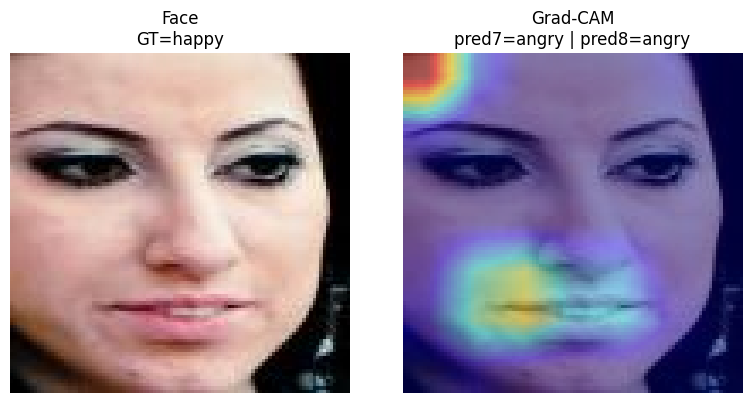

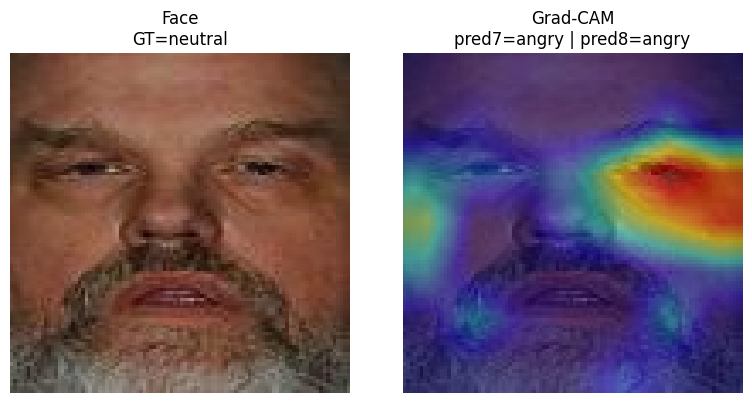

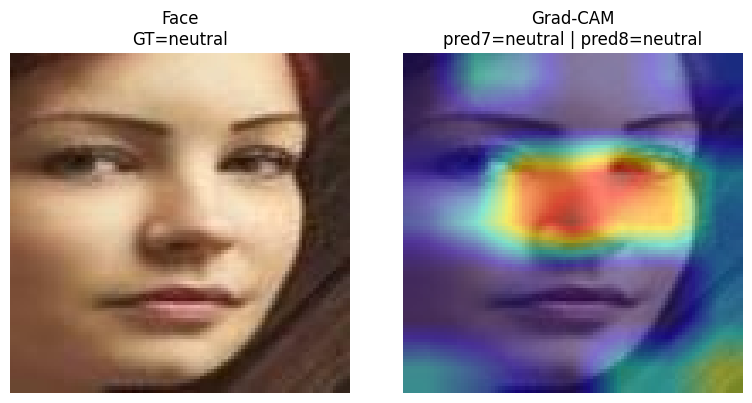

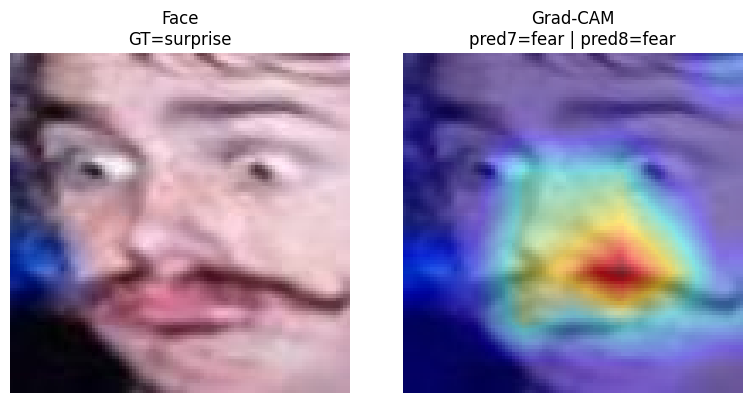

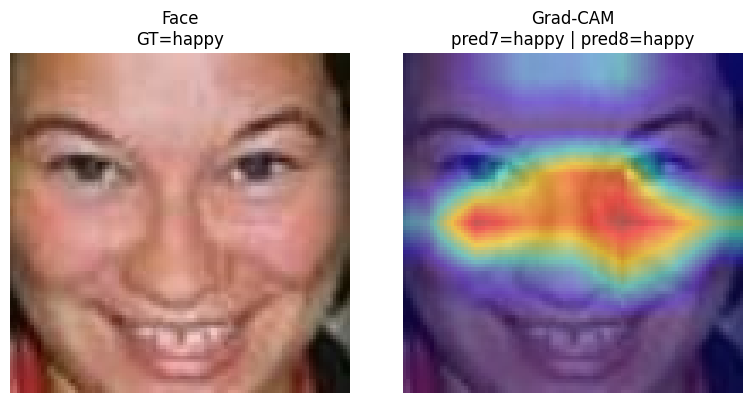

In [45]:
valid_idxs = np.where(valid)[0]
print("Valid count:", len(valid_idxs))

for i in valid_idxs[:5]:
    show_and_save_gradcam(int(i), save=True)

# Aggregated Grad-CAM

## Per emotion average

In [25]:
from collections import defaultdict
from tqdm import tqdm

def aggregate_gradcam_by_pred7(valid_indices, max_samples=50, conf_th=0.60, agg_size=224):
    """
    Builds average Grad-CAM heatmap per pred7_label (7-class).
    Uses y_pred_proba confidence for threshold.
    Aggregates resized heatmaps to (agg_size, agg_size) for consistency.
    """
    rng = np.random.default_rng(0)
    choose = valid_indices.copy()
    rng.shuffle(choose)
    choose = choose[:min(max_samples, len(choose))]

    per_emotion = defaultdict(list)
    counts_total = defaultdict(int)
    counts_kept = defaultdict(int)

    for i in tqdm(choose):
        i = int(i)
        pred7 = df_pred.loc[i, "pred7_label"]
        if pred7 is None:
            continue

        conf = float(np.max(y_pred_proba[i]))
        counts_total[pred7] += 1
        if conf < conf_th:
            continue

        path = df_pred.loc[i, "file_path"]
        face = read_rgb_uint8(path)
        if face is None:
            continue

        try:
            pred8_label, cam_map, face_disp, cam_vis, cam_uint8 = gradcam_on_face(face)

            # Skip if contempt or failure
            if cam_map is None:
                continue

            # Resize cam to fixed aggregation size
            cam_resized = cv2.resize(cam_map.astype(np.float32), (agg_size, agg_size), interpolation=cv2.INTER_LINEAR)

            # Normalize [0,1] before averaging (critical)
            cam_resized = np.maximum(cam_resized, 0)
            mn, mx = float(cam_resized.min()), float(cam_resized.max())
            cam_resized = (cam_resized - mn) / (mx - mn + 1e-8)

            per_emotion[pred7].append(cam_resized)
            counts_kept[pred7] += 1
        except Exception:
            continue

    avg_heatmaps = {}
    for emo, maps in per_emotion.items():
        if len(maps) == 0:
            continue
        avg_heatmaps[emo] = np.mean(np.stack(maps, axis=0), axis=0)

    print("Total sampled per pred7:", dict(counts_total))
    print("Kept (conf>=th) per pred7:", dict(counts_kept))

    return avg_heatmaps

avg_heatmaps = aggregate_gradcam_by_pred7(valid_idxs, max_samples=300, conf_th=0.60, agg_size=224)

100%|██████████| 293/293 [01:21<00:00,  3.60it/s]

Total sampled per pred7: {'angry': 42, 'sad': 64, 'happy': 94, 'surprise': 17, 'disgust': 10, 'fear': 21, 'neutral': 45}
Kept (conf>=th) per pred7: {'angry': 27, 'sad': 43, 'happy': 88, 'surprise': 9, 'disgust': 5, 'fear': 11, 'neutral': 31}


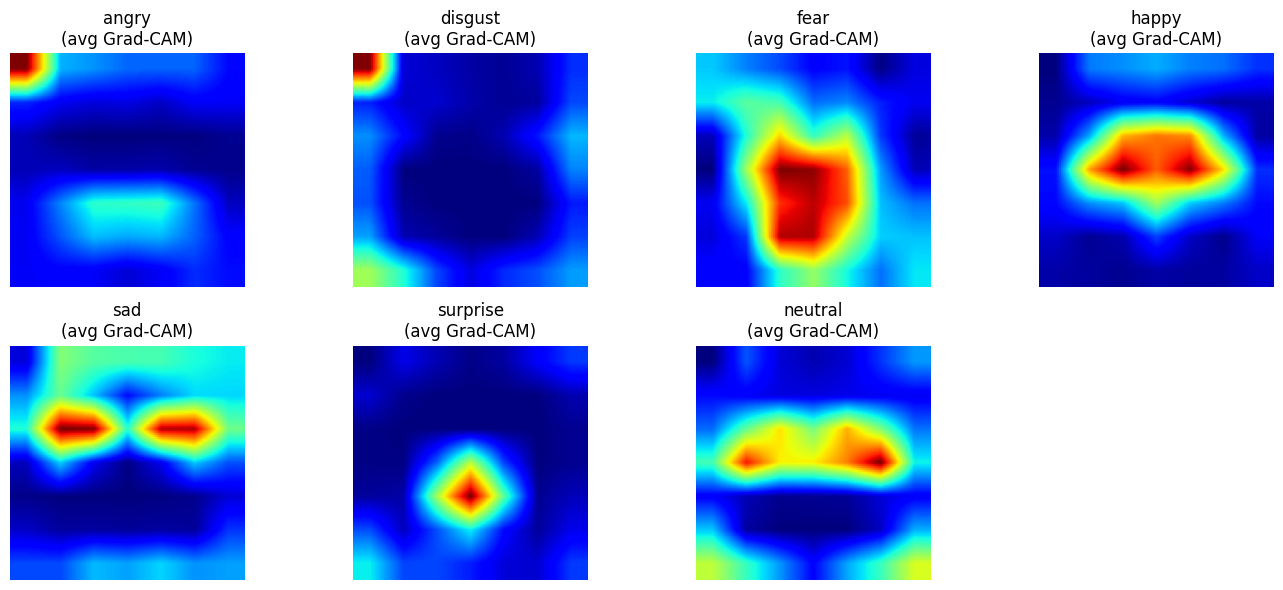

In [26]:
plt.figure(figsize=(14, 6))

for i, emo in enumerate(EMOTIONS):
    if emo not in avg_heatmaps:
        continue

    hmap = avg_heatmaps[emo]
    vis = cv2.resize(hmap, (128, 128), interpolation=cv2.INTER_CUBIC)
    vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-8)

    plt.subplot(2, 4, i+1)
    plt.title(f"{emo}\n(avg Grad-CAM)")
    plt.imshow(vis, cmap="jet")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Region-level attention

In [ ]:
def _clip_box(x1, y1, x2, y2, W, H):
    x1 = int(np.clip(x1, 0, W - 1))
    x2 = int(np.clip(x2, 0, W))
    y1 = int(np.clip(y1, 0, H - 1))
    y2 = int(np.clip(y2, 0, H))
    if x2 <= x1: x2 = min(W, x1 + 1)
    if y2 <= y1: y2 = min(H, y1 + 1)
    return x1, y1, x2, y2

def get_face_regions(H, W):
    eye_y1, eye_y2 = 0.18 * H, 0.42 * H
    eye_x1, eye_x2 = 0.18 * W, 0.82 * W

    nose_y1, nose_y2 = 0.35 * H, 0.65 * H
    nose_x1, nose_x2 = 0.35 * W, 0.65 * W

    mouth_y1, mouth_y2 = 0.62 * H, 0.88 * H
    mouth_x1, mouth_x2 = 0.25 * W, 0.75 * W

    return {
        "eyes":  _clip_box(eye_x1,  eye_y1,  eye_x2,  eye_y2,  W, H),
        "nose":  _clip_box(nose_x1, nose_y1, nose_x2, nose_y2, W, H),
        "mouth": _clip_box(mouth_x1, mouth_y1, mouth_x2, mouth_y2, W, H),
    }

def compute_region_fractions(face_rs_rgb_uint8, cam_map, eps=1e-8, priority=("eyes","nose","mouth")):
    """
    face_rs_rgb_uint8: resized face RGB (H,W,3) matching visualization size
    cam_map: (h,w) Grad-CAM map (float)
    """
    H, W = face_rs_rgb_uint8.shape[:2]
    hm = cv2.resize(cam_map.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
    hm = np.maximum(hm, 0.0)

    total = float(hm.sum()) + eps
    regions = get_face_regions(H, W)

    assigned = np.zeros((H, W), dtype=bool)
    region_sums = {}

    for name in priority:
        x1, y1, x2, y2 = regions[name]
        mask = np.zeros((H, W), dtype=bool)
        mask[y1:y2, x1:x2] = True
        mask = mask & (~assigned)
        assigned |= mask
        region_sums[name] = float(hm[mask].sum())

    other_sum = float(hm[~assigned].sum())

    fracs = {k: v/total for k, v in region_sums.items()}
    fracs["other"] = other_sum/total

    # normalize numeric drift
    s = sum(fracs.values())
    for k in fracs:
        fracs[k] /= s

    return fracs

### Build region dataframe for a subset + stacked bars

In [ ]:
def build_region_df(valid_indices, n_samples=100, conf_th=0.60):
    rng = np.random.default_rng(0)
    choose = valid_indices.copy()
    rng.shuffle(choose)
    choose = choose[:min(n_samples, len(choose))]

    rows = []
    for i in tqdm(choose):
        i = int(i)
        conf = float(np.max(y_pred_proba[i]))
        if conf < conf_th:
            continue

        path = df_pred.loc[i, "file_path"]
        true_label = df_pred.loc[i, "emotion_label"]
        pred7_label = df_pred.loc[i, "pred7_label"]

        face = read_rgb_uint8(path)
        if face is None:
            continue

        try:
            pred8_label, cam_map, face_rs, cam_vis = gradcam_on_face(face)
            fracs = compute_region_fractions(face_rs, cam_map)

            rows.append({
                "i": i,
                "true_label": true_label,
                "pred7_label": pred7_label,
                "pred8_label": pred8_label,
                "conf": conf,
                "eyes_frac": fracs["eyes"],
                "nose_frac": fracs["nose"],
                "mouth_frac": fracs["mouth"],
                "other_frac": fracs["other"],
            })
        except Exception:
            continue

    return pd.DataFrame(rows)

region_df = build_region_df(valid_idxs, n_samples=200, conf_th=0.60)
print(region_df.head())
print("region_df size:", region_df.shape)

# Save
region_df.to_csv(OUT_DIR / "region_fractions.csv", index=False)
print("Saved:", OUT_DIR / "region_fractions.csv")

100%|██████████| 97/97 [00:28<00:00,  3.41it/s]

    i true_label pred7_label pred8_label      conf  eyes_frac  nose_frac  \
0  99       fear        fear        fear  0.916462   0.246722   0.145349   
1  36    neutral     neutral     neutral  0.864811   0.030071   0.050442   
2  20      happy       happy       happy  0.980924   0.325894   0.231247   
3   5        sad       angry       angry  0.766598   0.012929   0.081060   
4  23    neutral     neutral     neutral  0.713836   0.347402   0.042950   

   mouth_frac  other_frac  
0    0.169603    0.438326  
1    0.022708    0.896779  
2    0.068556    0.374303  
3    0.328707    0.577304  
4    0.009385    0.600263  
region_df size: (71, 9)
Saved: /content/emotiefflib_protocolA_outputs/region_fractions.csv


### Plot stacked bars per **pred7_label**

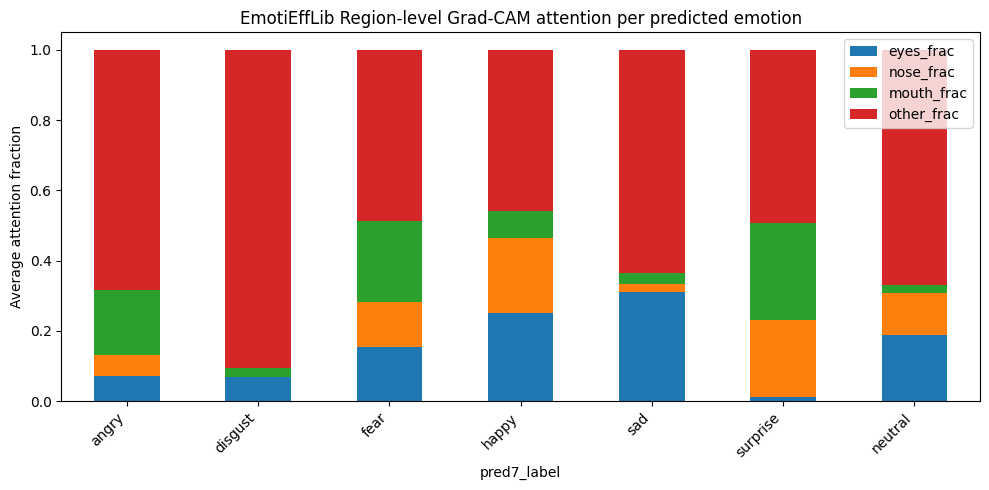

In [ ]:
avg_by_pred = (
    region_df
    .groupby("pred7_label")[["eyes_frac", "nose_frac", "mouth_frac", "other_frac"]]
    .mean()
    .reindex(EMOTIONS)
)

ax = avg_by_pred.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.ylabel("Average attention fraction")
plt.title("EmotiEffLib Region-level Grad-CAM attention per predicted emotion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Final grid plotting

In [42]:
def plot_explanation_rows(rows, save_path=None, dpi=160):
    """
    rows: list of dicts with keys:
      - face
      - heatmap
      - overlay
      - meta_lines : list[str]  (each item = one line of text)
    """
    n = len(rows)
    fig = plt.figure(figsize=(13, 3.2 * n), dpi=dpi)

    for r, row in enumerate(rows):
        # Face
        ax = plt.subplot(n, 3, r*3 + 1)
        ax.imshow(row["face"])
        ax.set_title("Face", fontsize=10)
        ax.axis("off")

        # Heatmap
        ax = plt.subplot(n, 3, r*3 + 2)
        if row["heatmap"] is None:
            ax.imshow(row["face"])
            ax.set_title("Attribution map (skipped)", fontsize=10)
        else:
            ax.imshow(row["heatmap"], cmap="jet")
            ax.set_title("Attribution map", fontsize=10)
        ax.axis("off")

        # Overlay
        ax = plt.subplot(n, 3, r*3 + 3)
        if row["overlay"] is None:
            ax.imshow(row["face"])
            ax.set_title("Overlay (skipped)", fontsize=10)
        else:
            ax.imshow(row["overlay"])
            ax.set_title("Overlay", fontsize=10)
        ax.axis("off")

        meta_text = "\n".join(row["meta_lines"])
        fig.text(
            0.01,
            1 - (r + 0.5) / n,
            meta_text,
            fontsize=12,
            va="center",
            ha="left"
        )

    plt.tight_layout(rect=[0.1, 0, 1, 1])

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")
        print("Saved:", save_path)

    plt.show()

In [43]:
def collect_gradcam_rows(indices, max_n=6):
    rows = []
    for i in indices[:max_n]:
        i = int(i)
        face = read_rgb_uint8(df_pred.loc[i, "file_path"])
        if face is None:
            continue

        pred8, cam_map, face_disp, overlay, cam_uint8 = gradcam_on_face(face)

        rows.append({
            "face": face_disp,
            "heatmap": cam_uint8,
            "overlay": overlay,
            "meta_lines": [
                f"idx = {i}",
                f"GT = {df_pred.loc[i,'emotion_label']}",
                f"pred7 = {df_pred.loc[i,'pred7_label']}",
                f"pred8 = {pred8}",
            ]
        })
    return rows

Saved: /content/emotiefflib_protocolA_outputs/gradcam_rows_protocolA.png


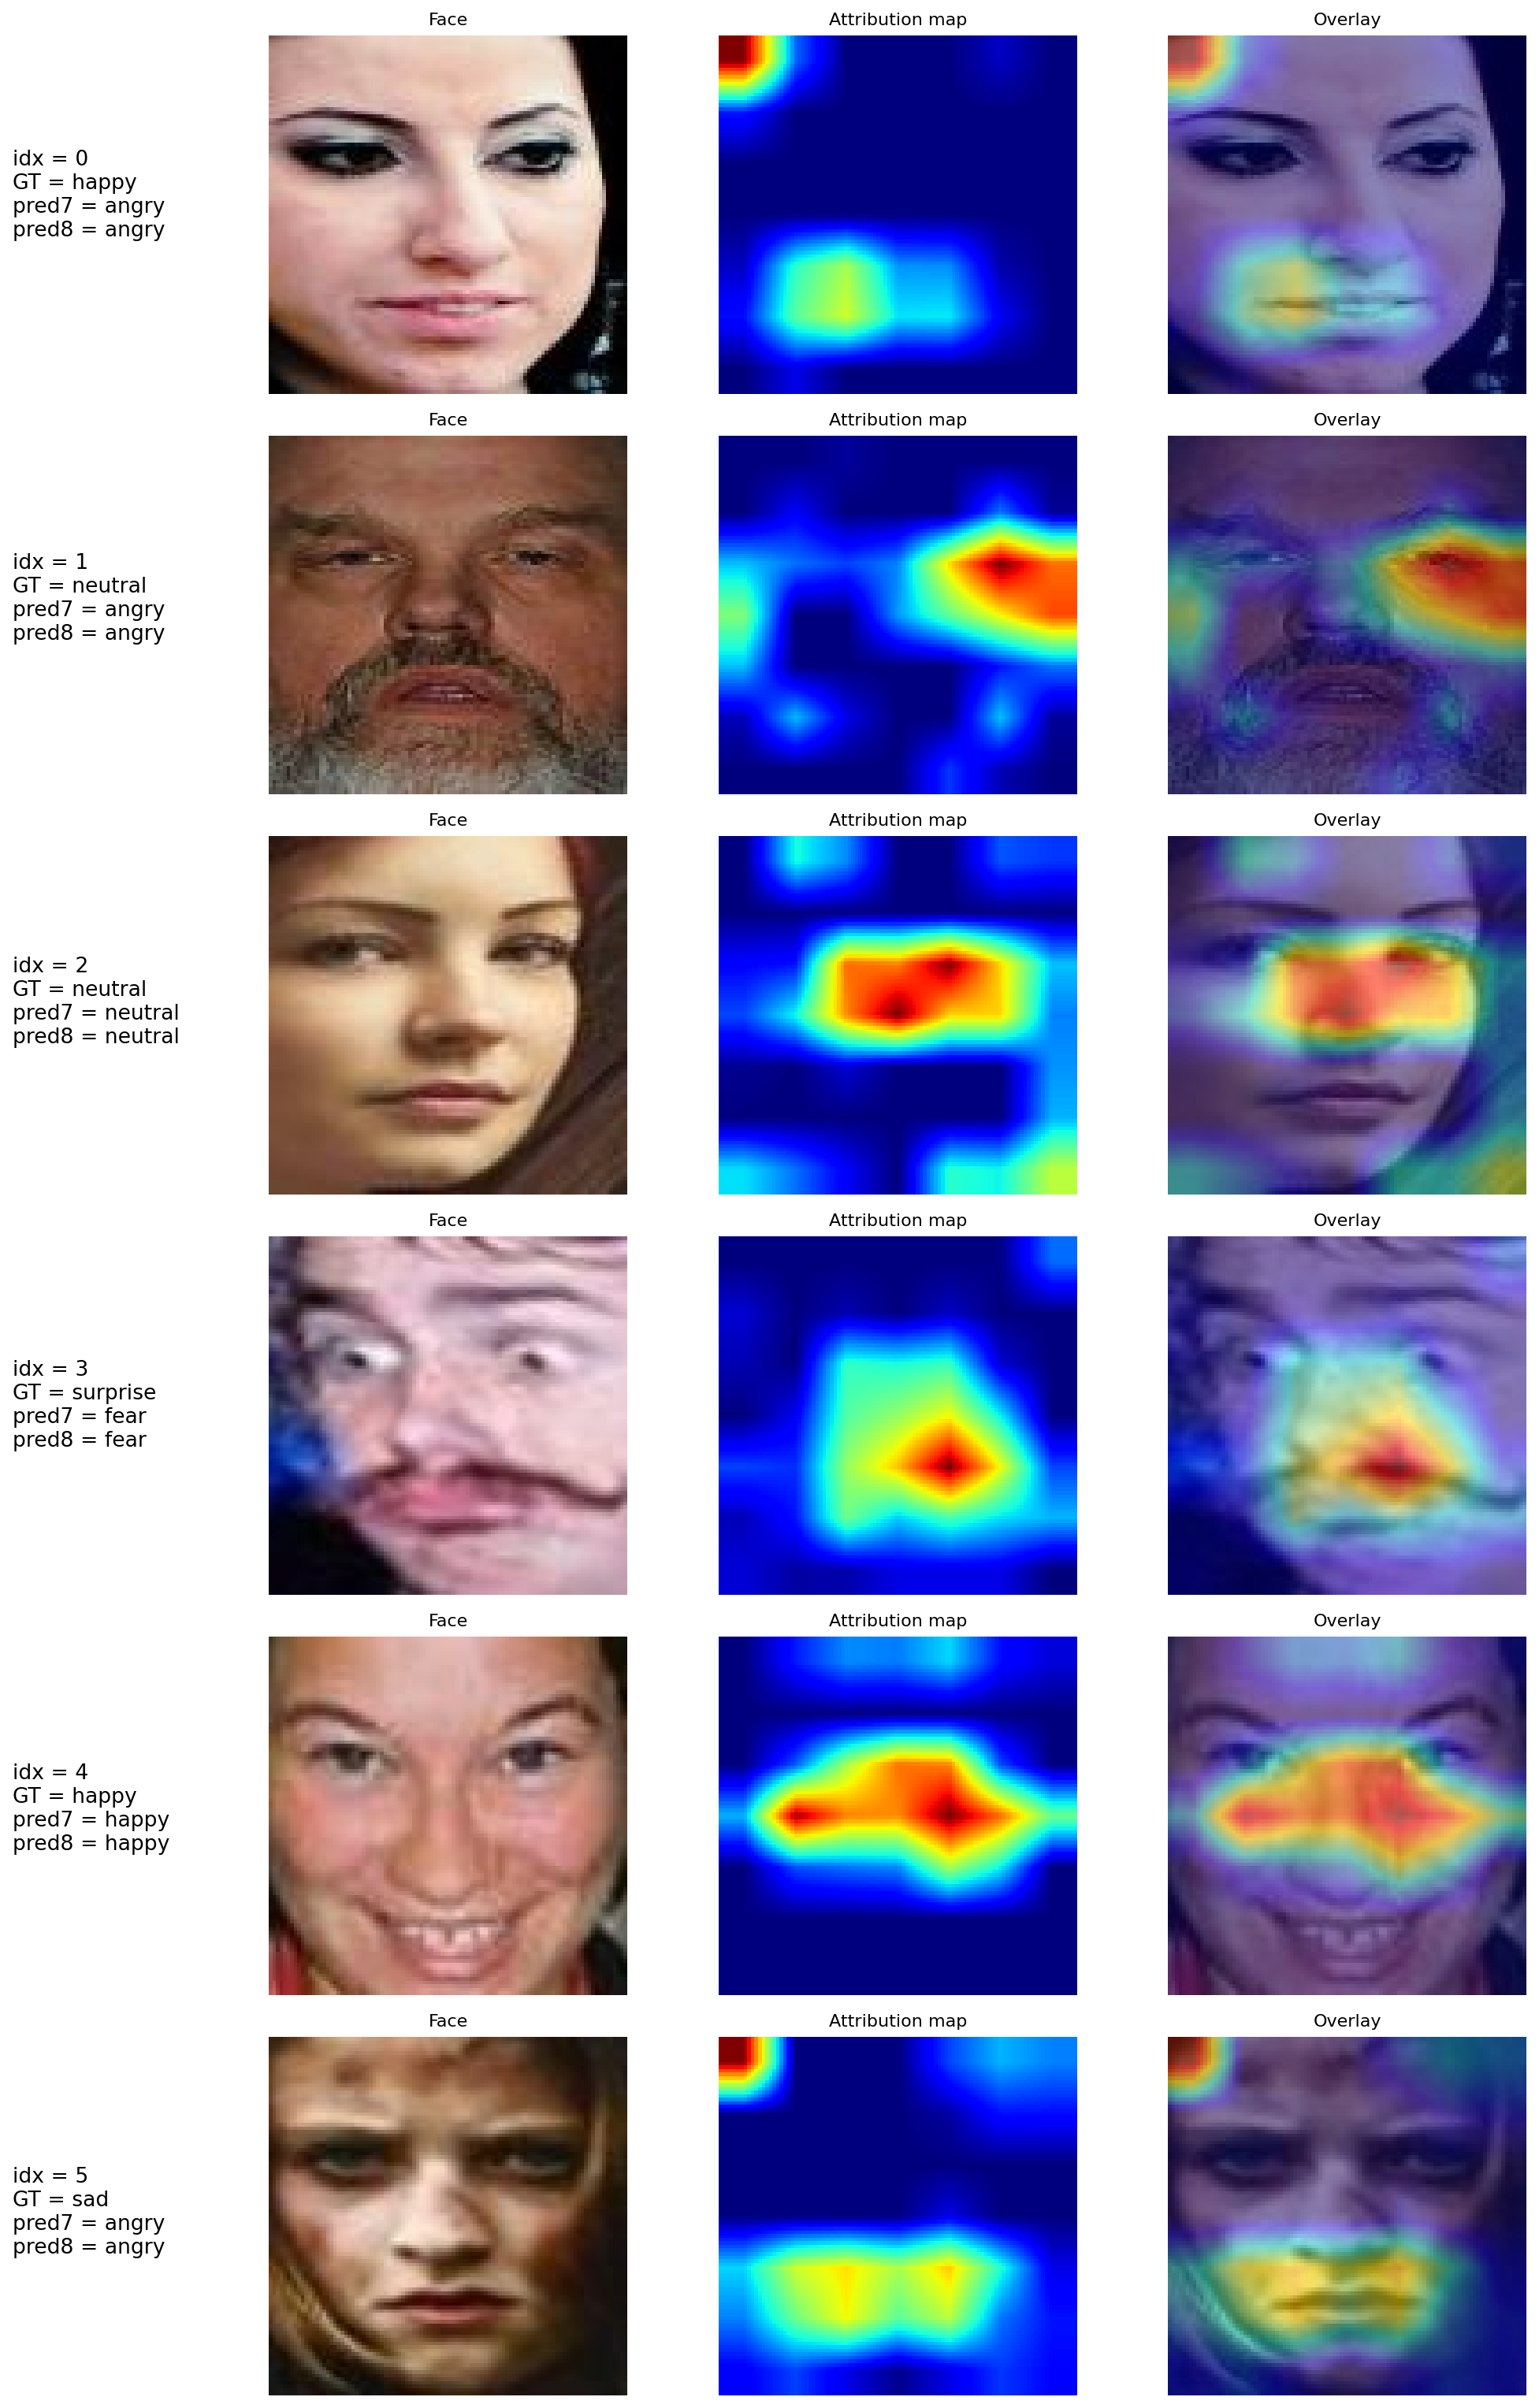

In [44]:
rows = collect_gradcam_rows(valid_idxs, max_n=6)
plot_explanation_rows(
    rows,
    save_path=OUT_DIR / "gradcam_rows_protocolA.png"
)

# Debug visualization for regions

Region attention fractions:
  eyes : 0.2467
  nose : 0.1453
  mouth: 0.1696
  other: 0.4383
  sum  : 1.0000


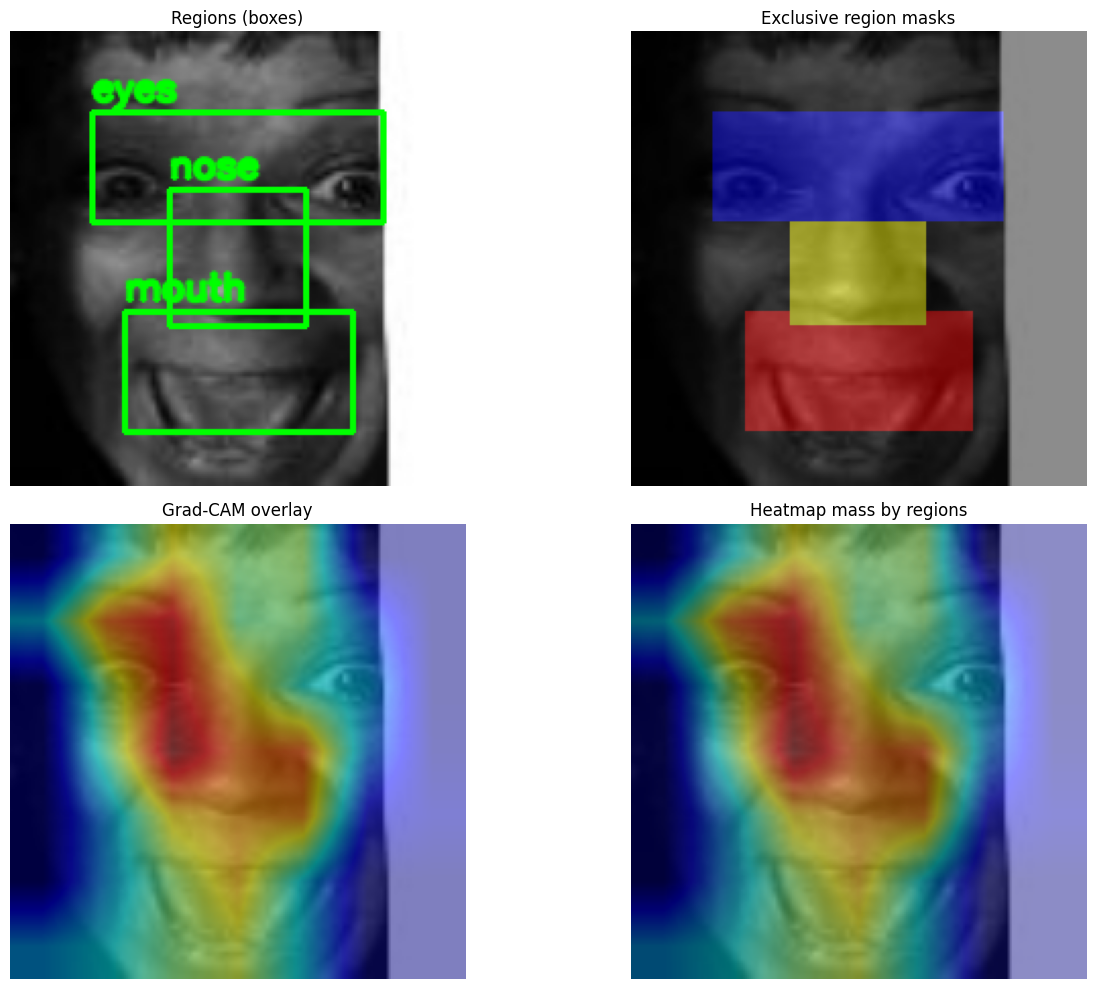

In [ ]:
def visualize_regions_and_attention(face_rs_rgb_uint8, cam_map, alpha=0.45, priority=("eyes","nose","mouth")):
    H, W = face_rs_rgb_uint8.shape[:2]
    hm = cv2.resize(cam_map.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
    hm = np.maximum(hm, 0.0)
    hm_norm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    regions = get_face_regions(H, W)

    assigned = np.zeros((H, W), dtype=bool)
    masks = {}
    for name in priority:
        x1,y1,x2,y2 = regions[name]
        m = np.zeros((H, W), dtype=bool)
        m[y1:y2, x1:x2] = True
        m = m & (~assigned)
        assigned |= m
        masks[name] = m
    masks["other"] = ~assigned

    img_boxes = face_rs_rgb_uint8.copy()
    for name,(x1,y1,x2,y2) in regions.items():
        cv2.rectangle(img_boxes, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img_boxes, name, (x1, max(0,y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

    # mask overlay
    region_colors = {
        "eyes":  (0, 0, 255),
        "nose":  (255, 255, 0),
        "mouth": (255, 0, 0),
        "other": (0, 0, 0),
    }
    mask_vis = np.zeros((H, W, 3), dtype=np.uint8)
    for name, m in masks.items():
        mask_vis[m] = region_colors[name]
    mask_overlay = cv2.addWeighted(face_rs_rgb_uint8, 1-alpha, mask_vis, alpha, 0)

    # CAM overlay
    face_float = face_rs_rgb_uint8.astype(np.float32)/255.0
    cam_vis = show_cam_on_image(face_float, hm_norm, use_rgb=True)

    # region mass overlay
    region_mass = np.zeros((H, W), dtype=np.float32)
    for name, m in masks.items():
        region_mass[m] = hm_norm[m]
    rm = cv2.applyColorMap(np.uint8(255 * region_mass), cv2.COLORMAP_JET)
    rm = cv2.cvtColor(rm, cv2.COLOR_BGR2RGB)
    region_mass_overlay = cv2.addWeighted(face_rs_rgb_uint8, 1-alpha, rm, alpha, 0)

    fracs = compute_region_fractions(face_rs_rgb_uint8, cam_map, priority=priority)
    print("Region attention fractions:")
    for k in ["eyes","nose","mouth","other"]:
        print(f"  {k:5s}: {fracs[k]:.4f}")
    print(f"  sum  : {sum(fracs.values()):.4f}")

    plt.figure(figsize=(14, 10))
    plt.subplot(2,2,1); plt.title("Regions (boxes)"); plt.imshow(img_boxes); plt.axis("off")
    plt.subplot(2,2,2); plt.title("Exclusive region masks"); plt.imshow(mask_overlay); plt.axis("off")
    plt.subplot(2,2,3); plt.title("Grad-CAM overlay"); plt.imshow(cam_vis); plt.axis("off")
    plt.subplot(2,2,4); plt.title("Heatmap mass by regions"); plt.imshow(region_mass_overlay); plt.axis("off")
    plt.tight_layout()
    plt.show()

# demo debug on one sample from region_df
if len(region_df) > 0:
    demo_i = int(region_df.iloc[0]["i"])
    face = read_rgb_uint8(df_pred.loc[demo_i, "file_path"])
    pred8_label, cam_map, face_rs, cam_vis = gradcam_on_face(face)
    visualize_regions_and_attention(face_rs, cam_map)

# **Results**

### **EmotiEffLib Evaluation on RAF-DB (7-Class, Contempt Dropped)**

We evaluated the EmotiEffLib emotion recognition model on the RAF-DB dataset under a 7-class evaluation setting consistent with RAF-DB annotations (*angry, disgust, fear, happy, sad, surprise, neutral*). Since EmotiEffLib natively predicts an additional emotion class (*contempt*), which is not present in RAF-DB, all samples for which the model's top-1 prediction was *contempt* were excluded from metric computation. This ensures a fair label-space alignment between model outputs and ground truth.


### **Coverage**
Out of 100 evaluated samples, 97 remained valid after excluding contempt predictions,
corresponding to a coverage of $97.0\%$.
This indicates that the model rarely resorts to the out-of-dataset class on RAF-DB,
and that most predictions can be meaningfully compared to the dataset labels.

### **CLassification performance**
On the valid subset, the model achieved a Top-1 accuracy of $43.3\%$ and a Top-3 accuracy
of $69.1\%$.
The weighted F1 score was $0.424$, while the macro F1 score was lower ($0.318$),
reflecting substantial class imbalance and uneven per-class performance.

Performance was highly class-dependent.
The model performed strongly on happy expressions (F1 $= 0.90$),
while emotions such as *surprise* and *neutral* exhibited near-zero recall.
This suggests a strong bias toward high-intensity, visually salient expressions,
with weaker discrimination for more subtle affective states.

### **Calibration**
Despite moderate classification accuracy, the model exhibited poor calibration.
The Expected Calibration Error (ECE) on the valid subset was $0.317$,
indicating that predicted confidence scores substantially overestimate true correctness.
This mismatch between confidence and accuracy is particularly concerning in downstream
or high-stakes applications.

## **Grad-CAM Analysis**
Grad-CAM visualizations were computed for all valid samples by targeting the model’s
predicted class.
Aggregated heatmaps revealed systematic and emotion-dependent attention patterns.
For example, predictions of *happy* were associated with strong activations in
the mouth region, while *fear* and *angry* predictions showed increased
attention toward the eye region.

### **Region-Level Attention Quantification**
To move beyond qualitative inspection, Grad-CAM heatmaps were decomposed into predefined
facial regions (eyes, nose, mouth, and other).
Across 71 high-confidence samples, a large fraction of attention mass consistently fell
outside canonical facial regions.
In a representative example, $24.7\%$ of attention was allocated to the eyes,
$14.5\%$ to the nose, and $17.0\%$ to the mouth, while $43.8\%$ was assigned to
non-specific regions.

These findings suggest that, although the model relies on semantically meaningful facial
areas for certain emotions, a substantial portion of its internal focus remains diffuse.
This diffuse attention may partially explain the model’s poor calibration and its
difficulty in reliably recognizing subtle expressions such *neutral* and *surprise*.
### **Summary**
Overall, EmotiEffLib demonstrates reasonable performance on RAF-DB when evaluated in a
label-aligned setting, but exhibits strong class biases, poor confidence calibration,
and diffuse attention patterns.
These characteristics motivate further analysis using occlusion-based experiments to
validate whether the highlighted regions are causally important for model decisions.


Authored by

*   Hassen Said Ali
*   Luwam Major Kefali
*   Hilina Fissha Woreta
